# ML Reglas de Precio Cocina Delirante

Objetivo: Identificar características importantes para asignación de reglas de precio e incremento de Ingresos (Estimated Revenue)

Variables disponibles cualitativas:  
    - Día (Day)CONFIGURABLE  
    - Día de la semana (Weekday)  
    - Sitio (Site) CONFIGURABLE  
    - Tamaño de creativo (Creative Size) CONFIGURABLE  
    - Dispositivo (Device category) CONFIGURABLE  
    - País (Country) CONFIGURABLE  
    - Nombre Regla de Precio (pricing rule name)

Variables disponibles cuantitativas:  
    - Regla de Precio
    - Ad Requests.  
    - Matched Requests.  
    - Clicks.  
    - Estimated Revenue  
    - Ad Impressions  
    - Active View Enabled Impressions  
    - Active View measured Impressions  
    
$$eCPM = \frac{Ingresos}{Impresiones Vendidas} * 1000$$  
$$Fill Rate = \frac{Impresiones Vendidas}{Oportunidades}$$  
$$rCPM = \frac{Ingresos}{Oportunidades} * 1000 = eCPM * Fill Rate$$  
$$Viewability = \frac{Impresiones Vistas}{Impresiones Disponibles} * 1000$$

Target: Maximizar ingresos (revenue)  
Inputs: weekday, site, creative_size, device_category, country.  
Output: Regla de Precio.

Nuevas modificaciones, añadir comparaciòn entre reglas de precio vs oportunidades y ad impressions.

In [183]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
from collections import Counter

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [184]:
# Carga de archivo base de datos con 9,994 registros, de los cuales información mensual desde Agosto 2020
import os
import tarfile
import urllib.request
import pandas as pd

PRULES_PATH = os.path.join("datasets")

def load_prules_data(prules_path=PRULES_PATH):
    csv_path = os.path.join(prules_path, "newbase_pricing_rules_open.csv")
    return pd.read_csv(csv_path)

# Carga y primera visualización de datos

In [185]:
# PARA PRIMERAS PRUEBAS Y ANÁLISIS DE COMPORTAMIENTO, TOMAMOS SOLAMENTE INFORMACIÓN DE DINERO EN IMAGEN.
# Visualización de la carga
target_site = 'Excelsior'

carga_prules = load_prules_data()
prules = carga_prules[carga_prules['site'] == target_site]

In [186]:
prules['rCPM'] = prules['revenue']/prules['ad_requests']*1000 #Modificar a eCPM
prules['FillRate'] = prules['ad_impressions']/prules['ad_requests']
prules['eCPM'] = prules['revenue']/prules['ad_impressions']*1000 #Modificar a eCPM
prules.head()

C:\Users\Aaron\AppData\Local\Temp\ipykernel_8612\811690050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prules['rCPM'] = prules['revenue']/prules['ad_requests']*1000 #Modificar a eCPM
C:\Users\Aaron\AppData\Local\Temp\ipykernel_8612\811690050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prules['FillRate'] = prules['ad_impressions']/prules['ad_requests']
C:\Users\Aaron\AppData\Local\Temp\ipykernel_8612\811690050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

,day,weekday,site,creative_size,device,country,pricing_rules_name,pricing_rules,ad_requests,matched_ad_requests,clicks,revenue,ad_impressions,active_view_enabled_impressions,active_view_measured_impressions,rCPM,FillRate,eCPM
0,28/04/2022,jue,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,16,1,0,0.05,1,1,1,3.125000,0.062500,50.0
1,29/04/2022,vie,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,20,1,0,0.00,0,0,0,0.000000,0.000000,NaN
2,30/04/2022,sáb,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,13,1,0,0.00,0,0,0,0.000000,0.000000,NaN
3,01/05/2022,dom,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,25,2,0,0.12,2,2,2,4.800000,0.080000,60.0
4,03/05/2022,mar,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,21,2,0,0.03,2,2,2,1.428571,0.095238,15.0


In [187]:
prules = prules[prules['FillRate']<=1]
prules = prules.reset_index(drop = True)

Saving figure scatter_matrix_plot


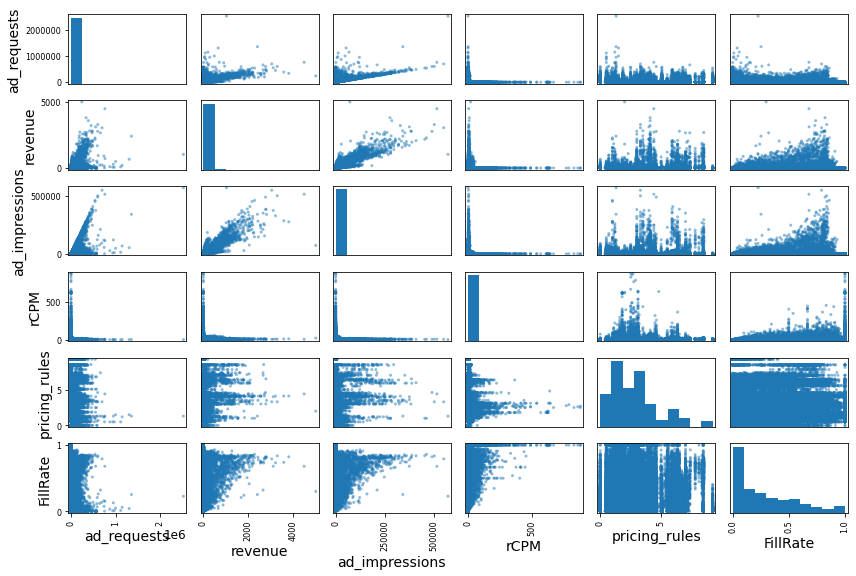

In [178]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
# Todas las gráficas se ven muy dispersas
from pandas.plotting import scatter_matrix

attributes = ["ad_requests", "revenue", "ad_impressions",
              "rCPM", 'pricing_rules', 'FillRate']
scatter_matrix(prules[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure scatter_matrix_plot


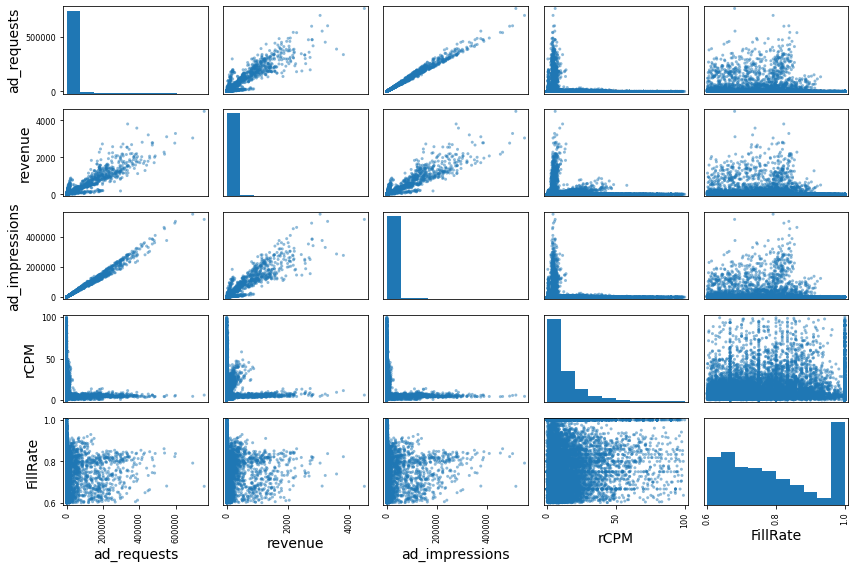

In [179]:
# Filtrando solamente las instancias que tienen Fill Rate superior a 60%.
# Se observam mejora en dispersión ad requests vs revenue.

prulesaux60 = prules[prules['FillRate']>.60]
prulesaux60 = prulesaux60[prulesaux60['rCPM']<100]
from pandas.plotting import scatter_matrix

attributes = ["ad_requests", "revenue", "ad_impressions", 'rCPM', 'FillRate']
scatter_matrix(prulesaux60[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [180]:
corr_matrix = prulesaux60.corr()
print(corr_matrix["revenue"].sort_values(ascending=False))
print('Registros: ',prulesaux60['day'].count())

revenue                             1.000000
ad_requests                         0.936334
ad_impressions                      0.933922
active_view_measured_impressions    0.933890
active_view_enabled_impressions     0.933844
matched_ad_requests                 0.932611
clicks                              0.859861
pricing_rules                       0.212236
rCPM                               -0.067129
FillRate                           -0.078227
Name: revenue, dtype: float64
Registros:  16103


Saving figure scatter_matrix_plot


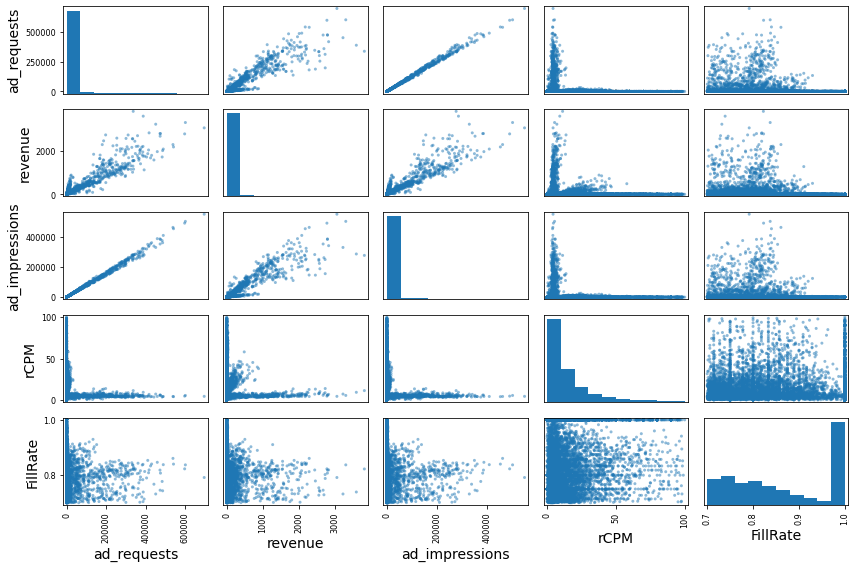

In [181]:
# Filtrando solamente las instancias que tienen Fill Rate superior a 70%.
# Se observam mejora en dispersión ad requests vs revenue.

prulesaux70 = prules[prules['FillRate']>.70]
prulesaux70 = prulesaux70[prulesaux70['rCPM']<100]
from pandas.plotting import scatter_matrix

attributes = ["ad_requests", "revenue", "ad_impressions", 'rCPM', 'FillRate']
scatter_matrix(prulesaux70[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [182]:
corr_matrix = prulesaux70.corr()
print(corr_matrix["revenue"].sort_values(ascending=False))
print('Registros: ',prulesaux70['day'].count())

revenue                             1.000000
ad_requests                         0.941957
active_view_enabled_impressions     0.938158
ad_impressions                      0.938149
active_view_measured_impressions    0.938127
matched_ad_requests                 0.936498
clicks                              0.845215
pricing_rules                       0.223540
rCPM                               -0.078600
FillRate                           -0.162520
Name: revenue, dtype: float64
Registros:  10675


Saving figure scatter_matrix_plot


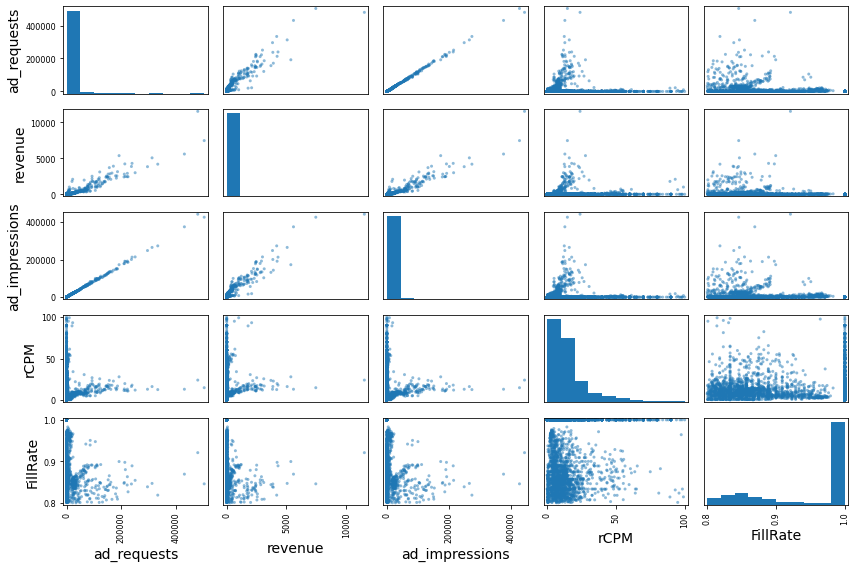

In [160]:
# Filtrando solamente las instancias que tienen Fill Rate superior a 80%.
# Se observam mejora en dispersión ad requests vs revenue.

prulesaux80 = prules[prules['FillRate']>.80]
prulesaux80 = prulesaux80[prulesaux80['rCPM']<100]
from pandas.plotting import scatter_matrix

attributes = ["ad_requests", "revenue", "ad_impressions", 'rCPM', 'FillRate']
scatter_matrix(prulesaux80[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [161]:
corr_matrix = prulesaux80.corr()
print(corr_matrix["revenue"].sort_values(ascending=False))
print('Registros: ',prulesaux80['day'].count())

revenue                             1.000000
clicks                              0.946343
active_view_measured_impressions    0.943797
active_view_enabled_impressions     0.943737
ad_impressions                      0.943627
ad_requests                         0.940767
matched_ad_requests                 0.940065
pricing_rules                       0.223991
rCPM                                0.033450
FillRate                           -0.207921
Name: revenue, dtype: float64
Registros:  4921


Saving figure scatter_matrix_plot


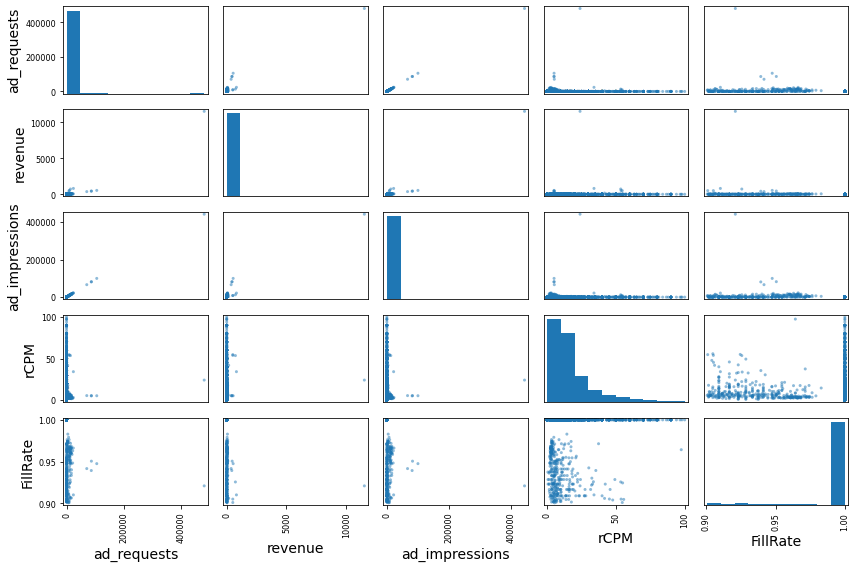

In [162]:
# Filtrando solamente las instancias que tienen Fill Rate superior a 90%.
# Se observam mejora en dispersión ad requests vs revenue.

prulesaux90 = prules[prules['FillRate']>.90]
prulesaux90 = prulesaux90[prulesaux90['rCPM']<100]
from pandas.plotting import scatter_matrix

attributes = ["ad_requests", "revenue", "ad_impressions", 'rCPM', 'FillRate']
scatter_matrix(prulesaux90[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [163]:
corr_matrix = prulesaux90.corr()
print(corr_matrix["revenue"].sort_values(ascending=False))
print('Registros: ',prulesaux90['day'].count())

revenue                             1.000000
clicks                              0.995237
ad_requests                         0.946089
matched_ad_requests                 0.945904
active_view_measured_impressions    0.942855
ad_impressions                      0.942665
active_view_enabled_impressions     0.942609
pricing_rules                       0.068890
rCPM                                0.013302
FillRate                           -0.095443
Name: revenue, dtype: float64
Registros:  3375


In [149]:
print(corr_matrix)

                                  pricing_rules  ad_requests  \
pricing_rules                          1.000000     0.067565   
ad_requests                            0.067565     1.000000   
matched_ad_requests                    0.067504     0.999990   
clicks                                 0.061708     0.958342   
revenue                                0.068890     0.946089   
ad_impressions                         0.067577     0.999935   
active_view_enabled_impressions        0.067562     0.999934   
active_view_measured_impressions       0.067590     0.999940   
rCPM                                   0.113521    -0.016764   
FillRate                              -0.176041    -0.163757   

                                  matched_ad_requests    clicks   revenue  \
pricing_rules                                0.067504  0.061708  0.068890   
ad_requests                                  0.999990  0.958342  0.946089   
matched_ad_requests                          1.000000  0.958344 

In [111]:
prules = prulesaux
prules.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9593 entries, 506 to 53767
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   day                               9593 non-null   object 
 1   weekday                           9593 non-null   object 
 2   site                              9593 non-null   object 
 3   creative_size                     9593 non-null   object 
 4   device                            9593 non-null   object 
 5   country                           9593 non-null   object 
 6   pricing_rules_name                9593 non-null   object 
 7   pricing_rules                     9593 non-null   float64
 8   ad_requests                       9593 non-null   int64  
 9   matched_ad_requests               9593 non-null   int64  
 10  clicks                            9593 non-null   int64  
 11  revenue                           9593 non-null   float64
 12  ad_

(0.5, 1.0, 0.0, 7000.0)

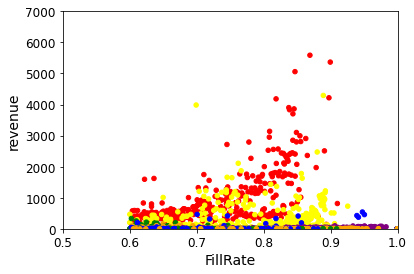

In [115]:
# Se observa que las instancias con mejor Fill Rate e ingresos son 
#prulesaux = prules[prules['creative_size'] == 'gen_amp']
prulesaux = prules
colors = {'Sin Posicion':'orange', '300x250':'green', '728x90':'blue', '320x100':'yellow', 'Zocalo':'purple', '1x1':'orange', 'gen_amp':'red', '300x600':'orange', 'Tags':'orange'}

prulesaux.plot(kind="scatter", x="FillRate", y="revenue", c= prulesaux['creative_size'].map(colors))
plt.axis([.5, 1, 0, 7000])
#plt.yscale("log")

In [ ]:
# Se observa que las instancias con mejor Fill Rate e ingresos son 
#prulesaux = prules[prules['creative_size'] == 'gen_amp']
prulesaux = prules
colors = {'Sin Posicion':'orange', '300x250':'green', '728x90':'blue', '320x100':'yellow', 'Zocalo':'purple', '1x1':'orange', 'gen_amp':'red', '300x600':'orange', 'Tags':'orange'}

prulesaux.plot(kind="scatter", x="FillRate", y="revenue", c= prulesaux['creative_size'].map(colors))
plt.axis([.5, 1, 0, 7000])
#plt.yscale("log")

(0.0, 400000.0, 0.0, 7000.0)

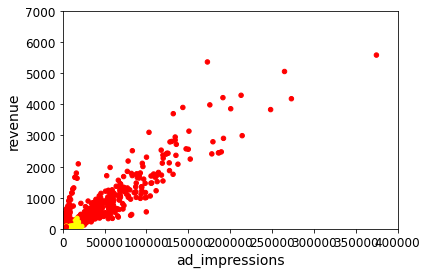

In [80]:
colorsd = {'Desktop':'yellow', 'High-end mobile devices':'red'}

prules.plot(kind="scatter", x="ad_impressions", y="revenue", c= prules['device'].map(colorsd))
plt.axis([0, 400000, 0, 7000])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9593 entries, 506 to 53767
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   day                               9593 non-null   object 
 1   weekday                           9593 non-null   object 
 2   site                              9593 non-null   object 
 3   creative_size                     9593 non-null   object 
 4   device                            9593 non-null   object 
 5   country                           9593 non-null   object 
 6   pricing_rules_name                9593 non-null   object 
 7   pricing_rules                     9593 non-null   float64
 8   ad_requests                       9593 non-null   int64  
 9   matched_ad_requests               9593 non-null   int64  
 10  clicks                            9593 non-null   int64  
 11  revenue                           9593 non-null   float64
 12  ad_

In [116]:
corr_matrix = prules.corr()
corr_matrix["FillRate"].sort_values(ascending=False)

FillRate                            1.000000
rCPM                                0.149073
clicks                             -0.036611
revenue                            -0.042826
active_view_measured_impressions   -0.044266
active_view_enabled_impressions    -0.044272
ad_impressions                     -0.044309
matched_ad_requests                -0.045628
ad_requests                        -0.060559
pricing_rules                      -0.062811
Name: FillRate, dtype: float64